# Spam Message Classifier End-to-End Project


In [23]:
import pandas as pd
import numpy as np


In [24]:

import re
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [25]:
# Load Dataset 
df = pd.read_csv("SPAM_text.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [27]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [28]:
df.duplicated().sum()

np.int64(415)

In [29]:
df.drop_duplicates(inplace = True)

In [30]:
df.duplicated().sum()

np.int64(0)

In [31]:
import re

In [32]:
# Preprocess data

df.columns = df.columns.str.strip().str.lower()
if "message" not in df.columns:
    df.rename(columns={df.columns[0]: "category", df.columns[1]: "message"}, inplace=True)

print("\nColumns:", df.columns)

# Encode target labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["category"])  # spam=1, ham=0

# masseges cleaning 
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www.\S+", " ", s)
    s = re.sub(r"\S+@\S+", " ", s)
    s = re.sub(r"\+?\d[\d\s-]{6,}\d", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_message"] = df["message"].apply(clean_text)
df[["message", "clean_message"]].head()


Columns: Index(['category', 'message'], dtype='object')


,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [33]:
df["label"].value_counts()

label
0    4516
1     641
Name: count, dtype: int64

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

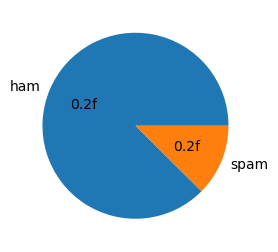

In [35]:
plt.figure(figsize=(3,4))
plt.pie(df["label"].value_counts() , labels = ["ham", "spam"] , autopct="0.2f")
plt.show()

In [36]:
# Train-Test Split

X = df["clean_message"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)


In [37]:
# Feature Engineering 

tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [38]:
from xgboost import XGBClassifier

In [39]:
# Models

models = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

leaderboard = []

for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    print(f" {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    leaderboard.append({"model": name, "accuracy": acc})


 Training LogisticRegression...
 LogisticRegression Accuracy: 0.9864
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       904
        spam       0.95      0.95      0.95       128

    accuracy                           0.99      1032
   macro avg       0.97      0.97      0.97      1032
weighted avg       0.99      0.99      0.99      1032

Confusion Matrix:
 [[897   7]
 [  7 121]]

 Training RandomForest...
 RandomForest Accuracy: 0.9806
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       904
        spam       0.99      0.85      0.92       128

    accuracy                           0.98      1032
   macro avg       0.99      0.93      0.95      1032
weighted avg       0.98      0.98      0.98      1032

Confusion Matrix:
 [[903   1]
 [ 19 109]]

 Training XGBoost...


C:\Users\csp\anaconda3\envs\myproj\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy: 0.9806
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       904
        spam       0.98      0.86      0.92       128

    accuracy                           0.98      1032
   macro avg       0.98      0.93      0.95      1032
weighted avg       0.98      0.98      0.98      1032

Confusion Matrix:
 [[902   2]
 [ 18 110]]


In [40]:
# Select Best Model 

leaderboard_df = pd.DataFrame(leaderboard).sort_values(by="accuracy", ascending=False)
print("\n Model Leaderboard:\n", leaderboard_df)

best_model_name = leaderboard_df.iloc[0]["model"]
best_model = models[best_model_name]
print(f"=="*30)
print(f"\n Best Model: {best_model_name}")



 Model Leaderboard:
                 model  accuracy
0  LogisticRegression  0.986434
1        RandomForest  0.980620
2             XGBoost  0.980620

 Best Model: LogisticRegression


In [41]:
# Save Artifacts 

joblib.dump(best_model, "spam_model_best.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(le, "label_encoder.joblib")
leaderboard_df.to_csv("leaderboard_metrics.csv", index=False)

print("\n Model + Vectorizer + Encoder saved successfully!")


 Model + Vectorizer + Encoder saved successfully!


In [42]:
# Prediction Function

def predict_message(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred = best_model.predict(vec)[0]
    prob = (
        best_model.predict_proba(vec)[:, 1][0]
        if hasattr(best_model, "predict_proba")
        else None
    )
    label = le.inverse_transform([pred])[0]
    return {"text": text, "label": label, "prob": float(prob) if prob is not None else None}

# Try Sample Predictions 

In [43]:


examples = [
    "Congratulations! You have won a $1000 gift card. Reply YES to claim.",
    "Hey, are we still meeting tomorrow for lunch?",
    "Urgent! Call this number now to get your prize."
]

print("\n Sample Predictions:")
for msg in examples:
    print(predict_message(msg))



 Sample Predictions:
{'text': 'Congratulations! You have won a $1000 gift card. Reply YES to claim.', 'label': 'spam', 'prob': 0.9295283906580505}
{'text': 'Hey, are we still meeting tomorrow for lunch?', 'label': 'ham', 'prob': 0.09054670771418849}
{'text': 'Urgent! Call this number now to get your prize.', 'label': 'spam', 'prob': 0.8591034803939875}
